# GBM for Predictive Maintenance using FD001 Dataset

This notebook demonstrates how to build a predictive maintenance model using the FD001 dataset from the NASA Turbofan Engine Degradation Simulation Data Set. The objective is to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings using an Gradient Boost Machine (GBM) model implemented with Pandas, NumPy, XGBoost (Extreme Gradient Boosting) and Scikit-Learn.


# Gradient Boosting Machine (GBM)
Gradient Boosting Machine (GBM) is an ensemble learning technique used for regression and classification tasks. It builds a model in a stage-wise fashion by combining multiple weak learners, typically decision trees, to create a strong predictive model. The key idea is to iteratively add models to minimize a specified loss function.

## Basic Concept
Gradient Boosting builds an additive model in a forward stage-wise manner:
- $ F_0(x) = \arg \min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma) $
- $ F_m(x) = F_{m-1}(x) + h_m(x) $
- where $ F_m(x) $ is the model after $ m $ iterations, $ h_m(x) $ is the $ m $-th weak learner (usually a decision tree), and $ L(y_i, F(x_i)) $ is the loss function.

## Gradient Descent
In gradient boosting, we use gradient descent to minimize the loss function. At each stage, a new weak learner $ h_m(x) $ is fitted to the residual errors (pseudo-residuals) of the existing model.

## Steps of Gradient Boosting
### Step 1: Initialize the Model with a Constant Value
$ F_0(x) = \arg \min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma) $

### Step 2: For Each Iteration $ m = 1 $ to $ M $
1. Compute the pseudo-residuals
$ r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} $
where $ r_{im} $ are the residuals for each sample $ i $ at iteration $ m $.

2. Fit a weak learner $ h_m(x) $ (e.g., a decision tree) to the pseudo-residuals:
$ h_m(x) = \arg \min_{h} \sum_{i=1}^{n} (r_{im} - h(x_i))^2 $

3. Update the model:
$ F_m(x) = F_{m-1}(x) + \nu h_m(x) $
where $ \nu $ is the learning rate, a small positive value (e.g., 0.1) that scales the contribution of each weak learner.

### Step 3: Output the Final Model
$ F_M(x) $

## Mathematical Details

### Initialization
For regression, if the loss function is the Mean Squared Error (MSE):
$ F_0(x) = \frac{1}{n} \sum_{i=1}^{n} y_i $

### Pseudo-Residuals
For MSE loss:
$ L(y_i, F(x_i)) = \frac{1}{2} (y_i - F(x_i))^2 $
The pseudo-residuals are:
$ r_{im} = y_i - F_{m-1}(x_i) $

### Weak Learner Fit
The weak learner $ h_m(x) $ is fitted to minimize the squared error of the residuals:
$ h_m(x) = \arg \min_{h} \sum_{i=1}^{n} (r_{im} - h(x_i))^2 $

### Model Update
The model is updated by adding the fitted weak learner scaled by the learning rate:
$ F_m(x) = F_{m-1}(x) + \nu h_m(x) $

## Visualization of Gradient Boosting Process

1. **Initial Model**: The initial model $ F_0(x) $ is a simple model, often just the mean of the target values.
2. **Pseudo-Residuals**: Calculate the residuals (errors) between the actual target values and the predictions of the current model.
3. **Fit Weak Learner**: Fit a weak learner (e.g., a decision tree) to these residuals.
4. **Update Model**: Add the weak learner's predictions to the current model's predictions.
5. **Repeat**: Iterate the process, updating the model with new weak learners fitted to the residuals from the previous iteration.

## Advantages of Gradient Boosting

1. **High Performance**: Can achieve very high predictive accuracy.
2. **Flexibility**: Can optimize a variety of loss functions and provides several hyperparameters for tuning.
3. **Handling Various Data Types**: Can handle numerical and categorical features well.

## Disadvantages of Gradient Boosting

1. **Computationally Intensive**: Training can be time-consuming, especially with large datasets.
2. **Prone to Overfitting**: Requires careful tuning of parameters like the number of trees, depth, and learning rate.
3. **Complexity**: Models are more complex and harder to interpret than single decision trees.

In [2]:
# Data Loading and Preprocessing
import numpy as np
import pandas as pd

# Normalization
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb

# Model Training
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
# Mean Squared Error - Calculates the root mean squared error regression loss to evaluate the performance of the model
# R^2 - Computes the R^2 to evaluate the goodness of fit of the model

# Visualization
import matplotlib.pyplot as plt

In [31]:
# Load data
file_prefix = 'FD001'
train_data_raw = pd.read_csv(f'CMAPSSData/train_{file_prefix}.txt', sep=' ', header=None)
test_data_raw = pd.read_csv(f'CMAPSSData/test_{file_prefix}.txt', sep=' ', header=None)
rul_data_raw = pd.read_csv(f'CMAPSSData/RUL_{file_prefix}.txt', header=None)

In [32]:
# Data Preprocessing - Data Cleaning
train_data = train_data_raw.drop(columns=[26, 27])
test_data = test_data_raw.drop(columns=[26, 27])
rul_data = rul_data_raw.copy(deep=True)

column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
               ['sensor_measurement_' + str(i) for i in range(1, 22)]

train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

# print(train_data.head())
# print(test_data.head())
# print(rul_data.head())

In [33]:
# Data Preprocessing - Normalization
scaler = StandardScaler()
train_data[train_data.columns[5:]] = scaler.fit_transform(train_data.iloc[:, 5:].values)
test_data[test_data.columns[5:]] = scaler.transform(test_data.iloc[:, 5:].values)

In [34]:
# Data Preprocessing - RUL Calculation
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform("max") - train_data['time_in_cycles']

In [35]:
# Data Preprocessing - Create aggregate features for XGBoost
def create_aggregate_features(data):
    features = data.groupby('unit_number').agg({
        'time_in_cycles': ['max'],
        'operational_setting_1': ['mean', 'std', 'last'],
        'operational_setting_2': ['mean', 'std', 'last'],
        'operational_setting_3': ['mean', 'std', 'last'],
        'sensor_measurement_1': ['mean', 'std', 'last'],
        'sensor_measurement_2': ['mean', 'std', 'last'],
        'sensor_measurement_3': ['mean', 'std', 'last'],
        'sensor_measurement_4': ['mean', 'std', 'last'],
        'sensor_measurement_5': ['mean', 'std', 'last'],
        'sensor_measurement_6': ['mean', 'std', 'last'],
        'sensor_measurement_7': ['mean', 'std', 'last'],
        'sensor_measurement_8': ['mean', 'std', 'last'],
        'sensor_measurement_9': ['mean', 'std', 'last'],
        'sensor_measurement_10': ['mean', 'std', 'last'],
        'sensor_measurement_11': ['mean', 'std', 'last'],
        'sensor_measurement_12': ['mean', 'std', 'last'],
        'sensor_measurement_13': ['mean', 'std', 'last'],
        'sensor_measurement_14': ['mean', 'std', 'last'],
        'sensor_measurement_15': ['mean', 'std', 'last'],
        'sensor_measurement_16': ['mean', 'std', 'last'],
        'sensor_measurement_17': ['mean', 'std', 'last'],
        'sensor_measurement_18': ['mean', 'std', 'last'],
        'sensor_measurement_19': ['mean', 'std', 'last'],
        'sensor_measurement_20': ['mean', 'std', 'last'],
        'sensor_measurement_21': ['mean', 'std', 'last'],
    })
    features.columns = ['_'.join(col) for col in features.columns]
    features.reset_index(inplace=True)
    return features
train_features = create_aggregate_features(train_data)
test_features = create_aggregate_features(test_data)

# print(train_features.head())
# print(train_FD001[['unit_number', 'RUL']].drop_duplicates().head())

train_features = train_features.merge(train_data[['unit_number', 'RUL']].drop_duplicates(), on='unit_number', how='left')

In [36]:
# Model Training - XGBoost
# Split training data into train and validation sets
X = train_features.drop(columns=['RUL', 'unit_number'])
y = train_features['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare test data
X_test = test_features.drop(columns=['unit_number'])

# Initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=10,
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:66.84008
[1]	validation_0-rmse:66.21729
[2]	validation_0-rmse:65.71623
[3]	validation_0-rmse:65.32767
[4]	validation_0-rmse:65.00168
[5]	validation_0-rmse:64.74008
[6]	validation_0-rmse:64.52610
[7]	validation_0-rmse:64.35042
[8]	validation_0-rmse:64.22373
[9]	validation_0-rmse:64.11557
[10]	validation_0-rmse:64.04119
[11]	validation_0-rmse:63.98408
[12]	validation_0-rmse:63.93743
[13]	validation_0-rmse:63.89927
[14]	validation_0-rmse:63.87310
[15]	validation_0-rmse:63.85387
[16]	validation_0-rmse:63.84445
[17]	validation_0-rmse:63.83296
[18]	validation_0-rmse:63.82666
[19]	validation_0-rmse:63.82349
[20]	validation_0-rmse:63.81714
[21]	validation_0-rmse:63.81275
[22]	validation_0-rmse:63.81495
[23]	validation_0-rmse:63.82218
[24]	validation_0-rmse:63.82337
[25]	validation_0-rmse:63.83104
[26]	validation_0-rmse:63.83264
[27]	validation_0-rmse:63.83453
[28]	validation_0-rmse:63.84466
[29]	validation_0-rmse:63.84996
[30]	validation_0-rmse:63.84705
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
# Model Evaluation
# Make predictions on test data
y_test_pred = xgb_model.predict(X_test)

# Align predicted RUL with actual RUL from the test set
rul_data = rul_data.iloc[:len(y_test_pred)]

# Evaluate the model
test_rmse = np.sqrt(mean_squared_error(rul_data, y_test_pred))
test_r2 = r2_score(rul_data, y_test_pred)

print(f'XGBoost Model - Test RMSE: {test_rmse}, Test R²: {test_r2}')

XGBoost Model - Test RMSE: 47.51050037520151, Test R²: -0.30713265547208835


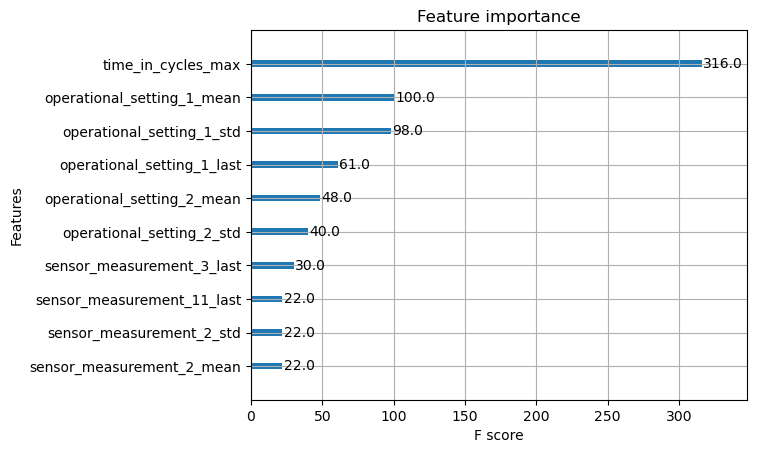

In [38]:
# Visualization - Plot feature importances
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

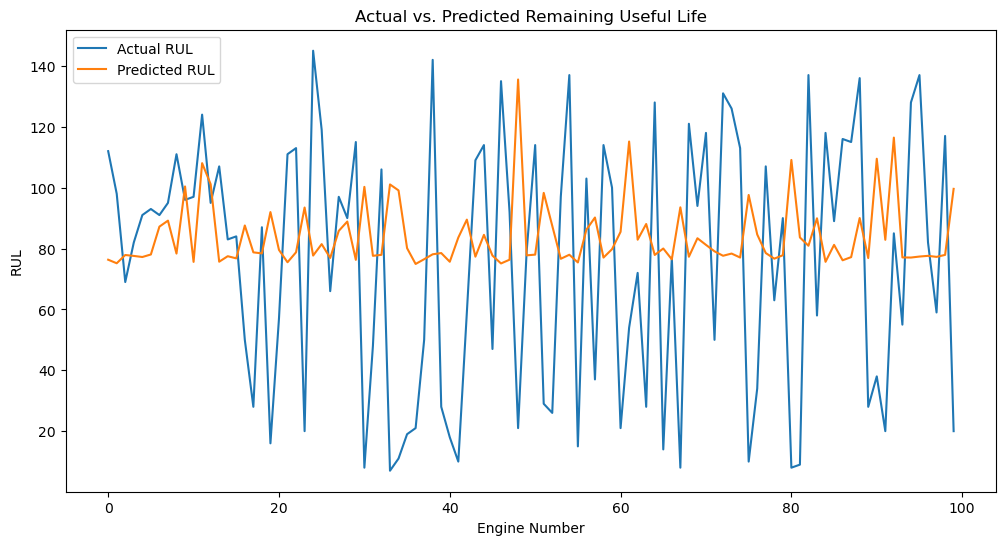

In [39]:
# Visualization - Plot actual vs. predicted RUL
plt.figure(figsize=(12, 6))
plt.plot(rul_data.values, label='Actual RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title('Actual vs. Predicted Remaining Useful Life')
plt.xlabel('Engine Number')
plt.ylabel('RUL')
plt.legend()
plt.show()

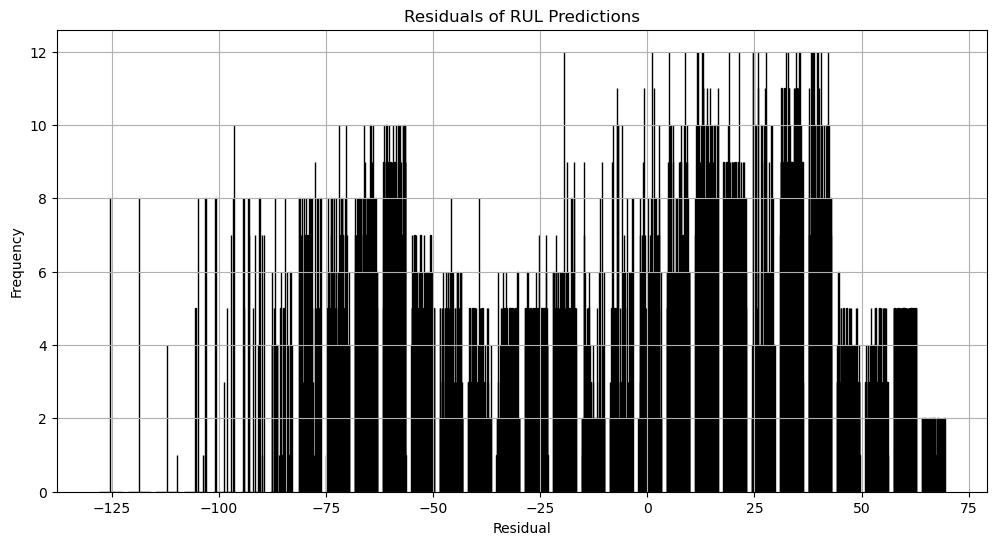

In [40]:
# Visualization - Plot residuals
residuals = rul_data.values - y_test_pred
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residuals of RUL Predictions')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Conclusion

In this notebook, a predictive maintenance model was built using the FD001 dataset. An GBM model was trained to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings. The model was evaluated using RMSE and R² scores, and the results were visualized to compare the actual vs. predicted RUL.
